# NuDiff Single Pair Pipeline

Notebook này nhận trực tiếp một cặp ảnh H&E và instance map, chạy toàn bộ pipeline NuDiff và visualize từng bước.

## Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from PIL import Image
from skimage import io
import scipy.io as sio
from tqdm import tqdm
from nudiff.struct_syn.datasets import get_hv
from nudiff.image_syn.utils.post_proc import get_instance_map
import os

## Load Input Pair of Images and Label

Nhập đường dẫn đến ảnh H&E và instance map.

Image shape: (1000, 1000, 3)
Instance map shape: (1000, 1000)
Number of nuclei: 480


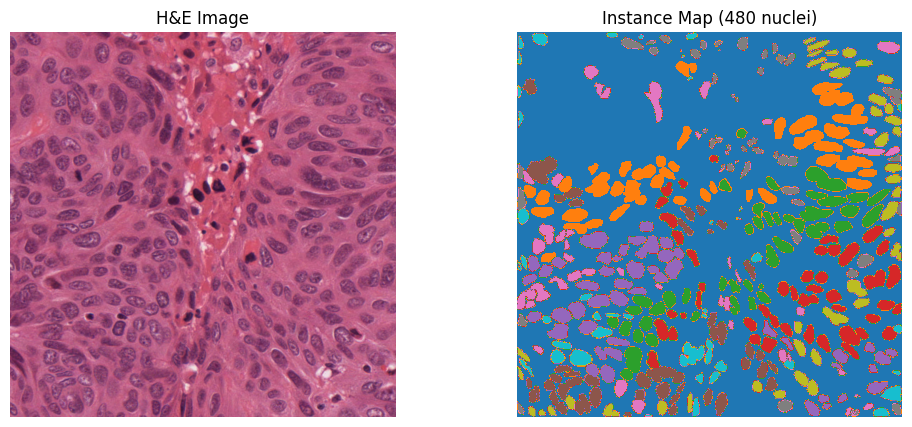

In [2]:
# Đường dẫn đến cặp ảnh (thay đổi theo nhu cầu)
image_path = r'D:\project\Nudiff\dataset\MoNuSeg\train\images\TCGA-18-5592-01Z-00-DX1.png'  # Ví dụ: 'monuseg/patches256x256_128/train_10pct/images/patch_00000.png'
label_path = r'D:\project\Nudiff\dataset\MoNuSeg\train\labels\TCGA-18-5592-01Z-00-DX1.mat'  # Ví dụ: 'monuseg/patches256x256_128/train_10pct/instances/patch_00000.npy'

# Load ảnh H&E
image = io.imread(image_path)
if image.ndim == 2:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
elif image.shape[-1] == 1:
    image = image.squeeze()
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Load instance map
if label_path.endswith('.mat'):
    label_mat = sio.loadmat(label_path)
    inst_map = label_mat['inst_map']
else:
    inst_map = np.load(label_path)

print(f"Image shape: {image.shape}")
print(f"Instance map shape: {inst_map.shape}")
print(f"Number of nuclei: {len(np.unique(inst_map)) - 1}")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(image)
ax1.set_title('H&E Image')
ax1.axis('off')
ax2.imshow(inst_map, cmap='tab10')
ax2.set_title(f'Instance Map ({len(np.unique(inst_map))-1} nuclei)')
ax2.axis('off')
plt.show()

## Image Preprocessing Step 1: Resize and Normalize

   Original image: 1000x1000
   Patch size: 256x256, Step: 128
   Grid: 6x6, Remainder flags: H:True, W:True
   Total patches extracted: 49
   Original image: 1000x1000
   Patch size: 256x256, Step: 128
   Grid: 6x6, Remainder flags: H:True, W:True
   Total patches extracted: 49
Total image patches: 49
Total instance map patches: 49


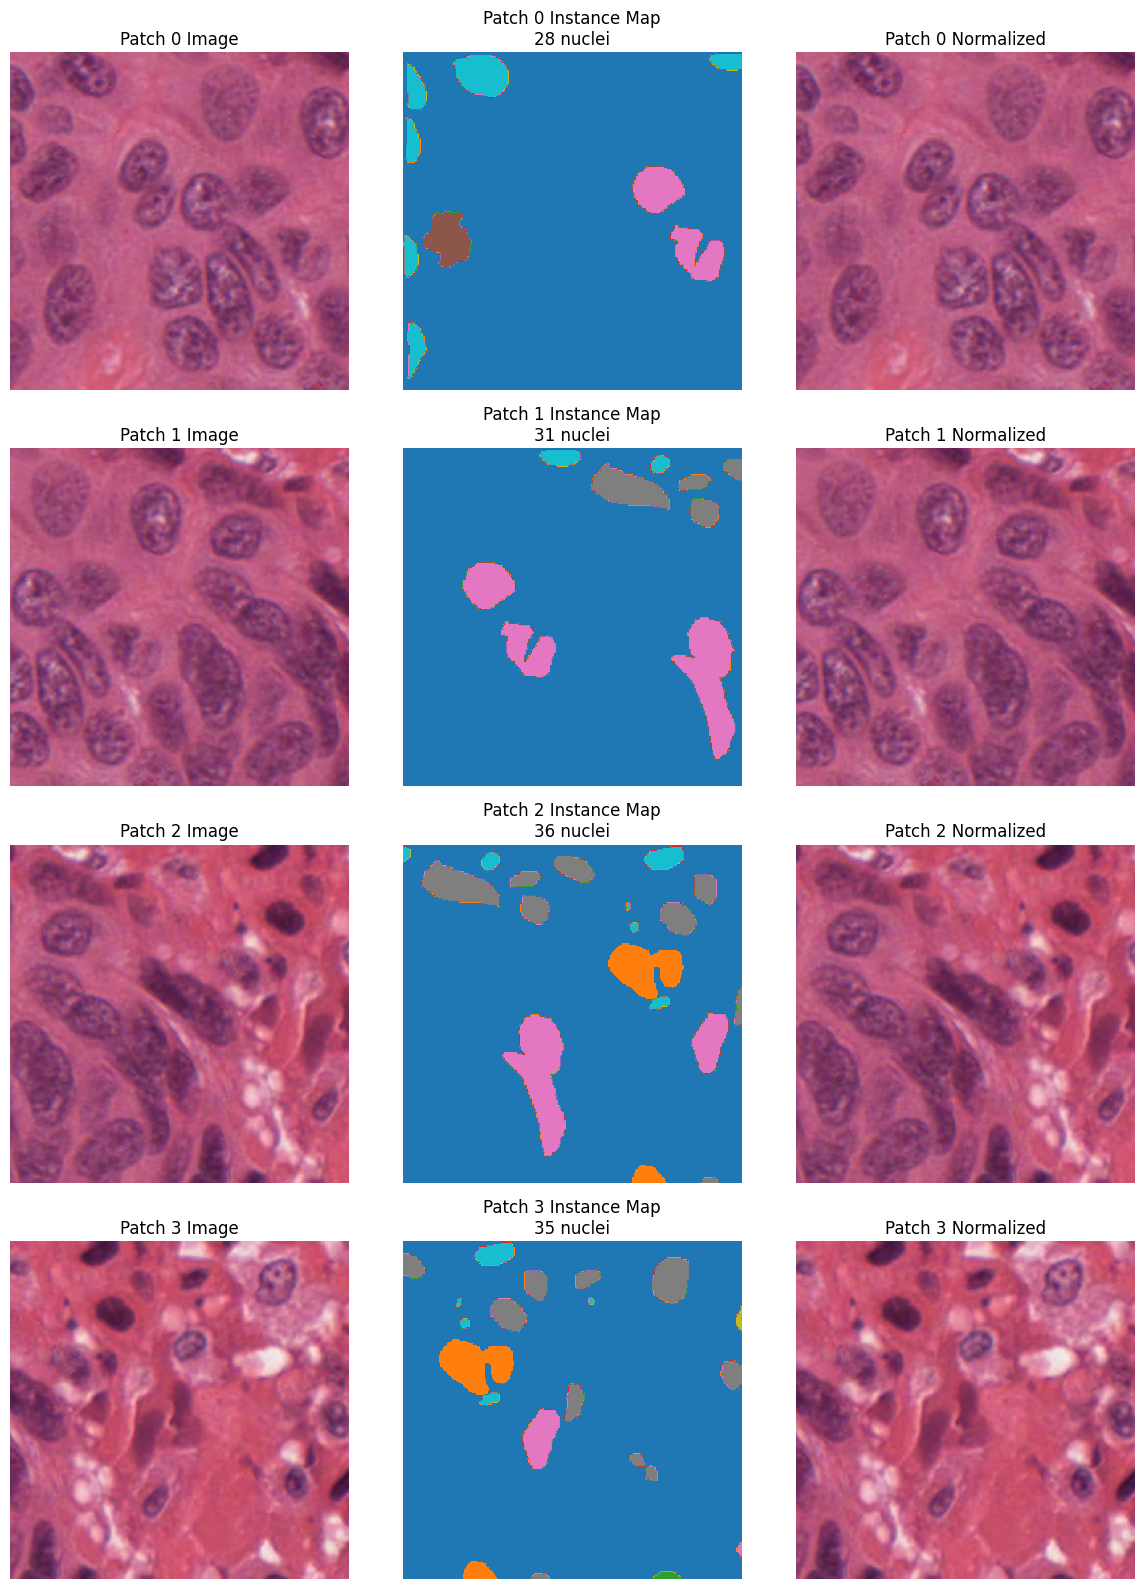

Selected patch 0 for further processing
Selected image shape: (256, 256, 3)
Selected instance map shape: (256, 256)


In [4]:
# Extract patches 256x256 with stride 128
def extract_patches(image, shape, step_size):
    H, W = image.shape[:2]
    h, w = shape
    assert H >= h, 'image height < patch height!'
    assert W >= w, 'image width < patch width!'
    hstep, wstep = (H - h) // step_size + 1, (W - w) // step_size + 1
    hflag, wflag = ((H - h) % step_size != 0), ((W - w) % step_size != 0)
    
    print(f"   Original image: {H}x{W}")
    print(f"   Patch size: {h}x{w}, Step: {step_size}")
    print(f"   Grid: {hstep}x{wstep}, Remainder flags: H:{hflag}, W:{wflag}")
    
    patches = []
    for i in range(hstep):
        for j in range(wstep):
            ytl, xtl = i * step_size, j * step_size
            ybr, xbr = ytl + h, xtl + w
            patch = image[ytl:ybr, xtl:xbr]
            patches.append(patch)
        if wflag:
            ytl, xtl = i * step_size, W - w
            ybr, xbr = ytl + h, W
            patch = image[ytl:ybr, xtl:xbr]
            patches.append(patch)
    if hflag:
        for j in range(wstep):
            ytl, xtl = H - h, j * step_size
            ybr, xbr = H, xtl + w
            patch = image[ytl:ybr, xtl:xbr]
            patches.append(patch)
    if hflag & wflag:
        patch = image[(H-h):H, (W-w):W]
        patches.append(patch)
    
    print(f"   Total patches extracted: {len(patches)}")
    return patches

patch_size = (256, 256)
step_size = 128

# Extract patches from image and instance map
image_patches = extract_patches(image, patch_size, step_size)
inst_map_patches = extract_patches(inst_map, patch_size, step_size)

print(f"Total image patches: {len(image_patches)}")
print(f"Total instance map patches: {len(inst_map_patches)}")

# Normalize image patches (0-1)
image_patches_normalized = [patch.astype(np.float32) / 255.0 for patch in image_patches]

# Visualize first few patches
num_vis = min(4, len(image_patches))
fig, axes = plt.subplots(num_vis, 3, figsize=(12, 4*num_vis))
if num_vis == 1:
    axes = axes.reshape(1, -1)

for i in range(num_vis):
    axes[i, 0].imshow(image_patches[i])
    axes[i, 0].set_title(f'Patch {i} Image')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(inst_map_patches[i], cmap='tab10')
    nuclei_count = len(np.unique(inst_map_patches[i])) - 1
    axes[i, 1].set_title(f'Patch {i} Instance Map\n{nuclei_count} nuclei')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(image_patches_normalized[i])
    axes[i, 2].set_title(f'Patch {i} Normalized')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

# Select one patch for further processing (e.g., first one)
selected_patch_idx = 0
image_selected = image_patches[selected_patch_idx]
inst_map_selected = inst_map_patches[selected_patch_idx]
image_normalized = image_patches_normalized[selected_patch_idx]

print(f"Selected patch {selected_patch_idx} for further processing")
print(f"Selected image shape: {image_selected.shape}")
print(f"Selected instance map shape: {inst_map_selected.shape}")

## Image Preprocessing Step 2: Augmentation

Applied horizontal flip augmentation


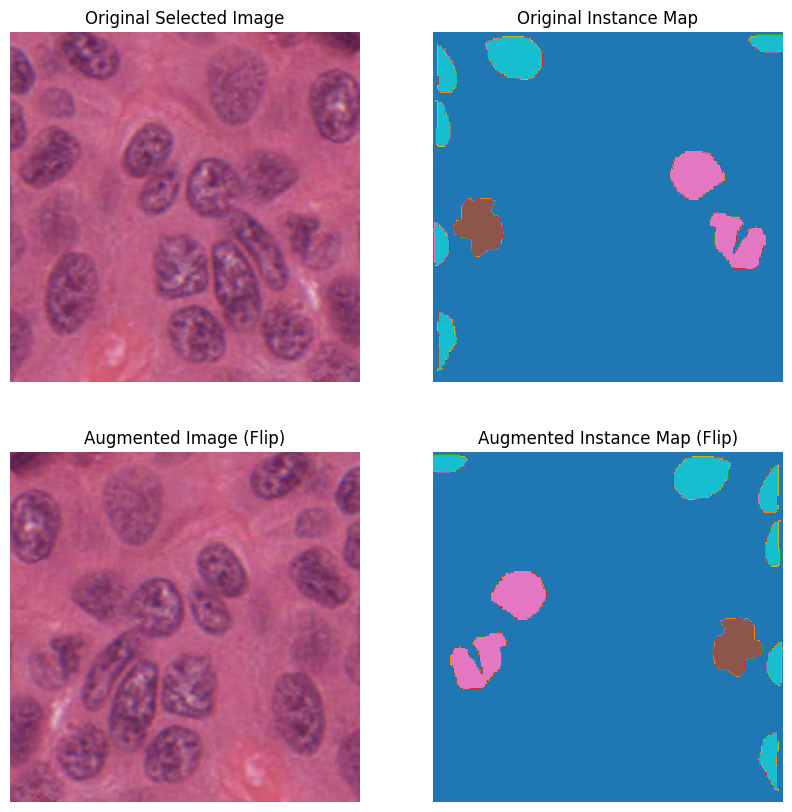

In [5]:
# Áp dụng augmentation (ví dụ: horizontal flip)
image_aug = cv2.flip(image_selected, 1)  # Horizontal flip
inst_map_aug = cv2.flip(inst_map_selected, 1)

print("Applied horizontal flip augmentation")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0,0].imshow(image_selected)
axes[0,0].set_title('Original Selected Image')
axes[0,0].axis('off')
axes[0,1].imshow(inst_map_selected, cmap='tab10')
axes[0,1].set_title('Original Instance Map')
axes[0,1].axis('off')
axes[1,0].imshow(image_aug)
axes[1,0].set_title('Augmented Image (Flip)')
axes[1,0].axis('off')
axes[1,1].imshow(inst_map_aug, cmap='tab10')
axes[1,1].set_title('Augmented Instance Map (Flip)')
axes[1,1].axis('off')
plt.show()

## Label Processing

Tạo nuclei structure từ instance map.

Structure shape: (256, 256, 3)
Semantic coverage: 0.426


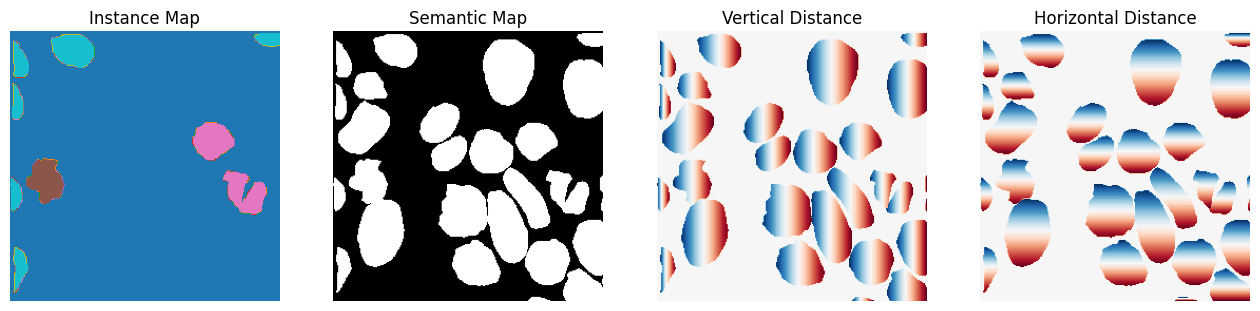

In [6]:
# Tạo nuclei structure từ instance map
semantic = (inst_map_selected > 0).astype(np.uint8)
hv_map = get_hv(inst_map_selected)
structure = np.stack([semantic, hv_map[..., 0], hv_map[..., 1]], axis=-1)

print(f"Structure shape: {structure.shape}")
print(f"Semantic coverage: {semantic.sum() / semantic.size:.3f}")

# Visualize structure
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(inst_map_selected, cmap='tab10')
axes[0].set_title('Instance Map')
axes[0].axis('off')
axes[1].imshow(semantic, cmap='gray')
axes[1].set_title('Semantic Map')
axes[1].axis('off')
axes[2].imshow(hv_map[..., 0], cmap='RdBu_r', vmin=-1, vmax=1)
axes[2].set_title('Vertical Distance')
axes[2].axis('off')
axes[3].imshow(hv_map[..., 1], cmap='RdBu_r', vmin=-1, vmax=1)
axes[3].set_title('Horizontal Distance')
axes[3].axis('off')
plt.show()

Semantic shape: (256, 256), dtype: uint8
HV map shape: (256, 256, 2), dtype: float32
Semantic coverage: 0.426
HV map range: v_dist [-1.000, 1.000], h_dist [-1.000, 1.000]

=== STRUCTURE VISUALIZATION ===


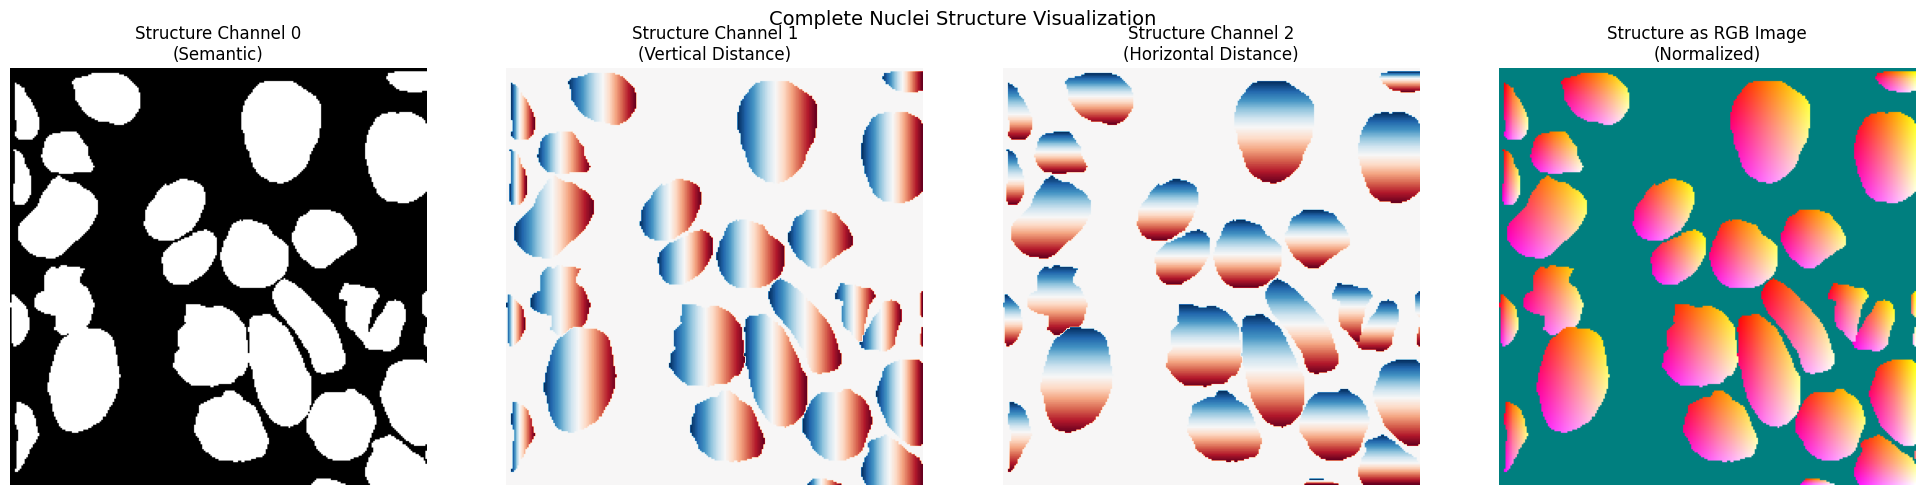

In [12]:
# Tạo nuclei structure từ instance map
semantic = (inst_map_selected > 0).astype(np.uint8)
hv_map = get_hv(inst_map_selected)

print(f"Semantic shape: {semantic.shape}, dtype: {semantic.dtype}")
print(f"HV map shape: {hv_map.shape}, dtype: {hv_map.dtype}")
print(f"Semantic coverage: {semantic.sum() / semantic.size:.3f}")
print(f"HV map range: v_dist [{hv_map[..., 0].min():.3f}, {hv_map[..., 0].max():.3f}], h_dist [{hv_map[..., 1].min():.3f}, {hv_map[..., 1].max():.3f}]")

# Tổng hợp 3 kênh thành cấu trúc nhân hoàn chỉnh
structure = np.stack([semantic, hv_map[..., 0], hv_map[..., 1]], axis=-1)

# Visualize structure hoàn chỉnh
print("\n=== STRUCTURE VISUALIZATION ===")
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Hiển thị từng kênh riêng lẻ
axes[0].imshow(structure[..., 0], cmap='gray')
axes[0].set_title('Structure Channel 0\n(Semantic)')
axes[0].axis('off')

axes[1].imshow(structure[..., 1], cmap='RdBu_r', vmin=-1, vmax=1)
axes[1].set_title('Structure Channel 1\n(Vertical Distance)')
axes[1].axis('off')

axes[2].imshow(structure[..., 2], cmap='RdBu_r', vmin=-1, vmax=1)
axes[2].set_title('Structure Channel 2\n(Horizontal Distance)')
axes[2].axis('off')

# Hiển thị structure như RGB image (normalize về 0-1)
structure_norm = structure.copy().astype(np.float32)
structure_norm[..., 0] = structure_norm[..., 0]  # Semantic 0-1
structure_norm[..., 1] = (structure_norm[..., 1] + 1) / 2  # V-dist -1..1 -> 0..1
structure_norm[..., 2] = (structure_norm[..., 2] + 1) / 2  # H-dist -1..1 -> 0..1

axes[3].imshow(structure_norm)
axes[3].set_title('Structure as RGB Image\n(Normalized)')
axes[3].axis('off')

plt.suptitle('Complete Nuclei Structure Visualization', fontsize=14)
plt.tight_layout()
plt.show()

Reconstructing instance map from structure using watershed...
Original instance map shape: (256, 256)
Reconstructed instance map shape: (256, 256)
Original nuclei count: 28
Reconstructed nuclei count: 268


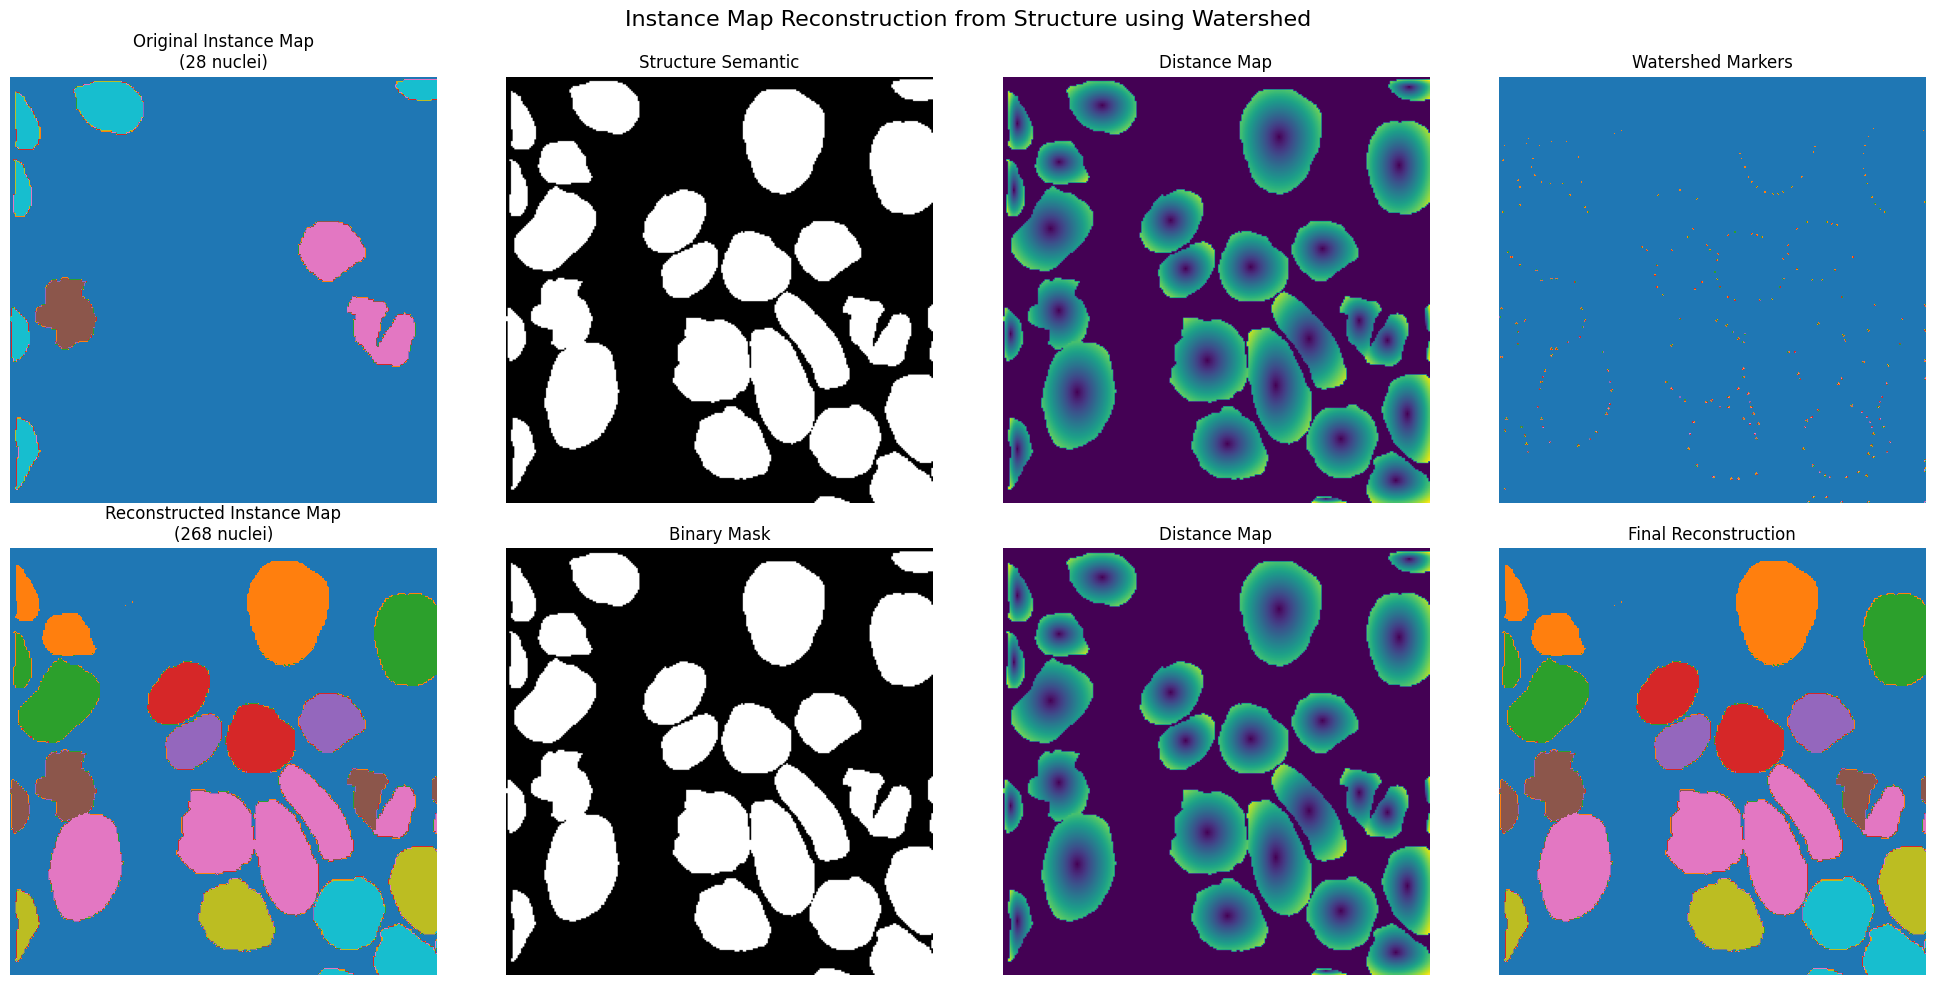


 RECONSTRUCTION COMPARISON
Original nuclei: 28
Reconstructed nuclei: 268
Difference: 240
Reconstruction completed!


In [14]:
from scipy.ndimage import maximum_filter
from scipy import ndimage
from skimage.segmentation import watershed

def structure_to_instance(structure):
    """
    Reconstruct instance map from nuclei structure using watershed algorithm.
    
    Args:
        structure: 3-channel array (H, W, 3) with [semantic, v_dist, h_dist]
    
    Returns:
        instance_map: (H, W) array with instance IDs
    """
    semantic, v_dist, h_dist = structure[..., 0], structure[..., 1], structure[..., 2]
    
    # Threshold semantic at 0.5 for binary mask
    binary = (semantic > 0.5).astype(np.uint8)
    
    # Distance from center (higher values = farther from center)
    dist_map = np.sqrt(v_dist**2 + h_dist**2)
    
    # Find local maxima as nucleus markers using maximum_filter
    local_max = (dist_map == maximum_filter(dist_map, size=5))
    markers = ndimage.label(local_max * binary)[0]
    
    # Watershed segmentation
    instance_map = watershed(dist_map, markers, mask=binary)
    return instance_map, dist_map, markers, binary

# Áp dụng watershed để reconstruct instance map từ structure
print("Reconstructing instance map from structure using watershed...")
reconstructed_inst_map, dist_map, markers, binary_mask = structure_to_instance(structure)

print(f"Original instance map shape: {inst_map_selected.shape}")
print(f"Reconstructed instance map shape: {reconstructed_inst_map.shape}")
print(f"Original nuclei count: {len(np.unique(inst_map_selected)) - 1}")
print(f"Reconstructed nuclei count: {len(np.unique(reconstructed_inst_map)) - 1}")

# Visualize reconstruction process
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Row 1: Original
axes[0,0].imshow(inst_map_selected, cmap='tab10')
axes[0,0].set_title(f'Original Instance Map\n({len(np.unique(inst_map_selected))-1} nuclei)')
axes[0,0].axis('off')

axes[0,1].imshow(structure[..., 0], cmap='gray')
axes[0,1].set_title('Structure Semantic')
axes[0,1].axis('off')

axes[0,2].imshow(dist_map, cmap='viridis')
axes[0,2].set_title('Distance Map')
axes[0,2].axis('off')

axes[0,3].imshow(markers, cmap='tab10')
axes[0,3].set_title('Watershed Markers')
axes[0,3].axis('off')

# Row 2: Reconstruction
axes[1,0].imshow(reconstructed_inst_map, cmap='tab10')
axes[1,0].set_title(f'Reconstructed Instance Map\n({len(np.unique(reconstructed_inst_map))-1} nuclei)')
axes[1,0].axis('off')

axes[1,1].imshow(binary_mask, cmap='gray')
axes[1,1].set_title('Binary Mask')
axes[1,1].axis('off')

axes[1,2].imshow(dist_map, cmap='viridis')
axes[1,2].set_title('Distance Map')
axes[1,2].axis('off')

axes[1,3].imshow(reconstructed_inst_map, cmap='tab10')
axes[1,3].set_title('Final Reconstruction')
axes[1,3].axis('off')

plt.suptitle('Instance Map Reconstruction from Structure using Watershed', fontsize=16)
plt.tight_layout()
plt.show()

# So sánh chi tiết
print("\n RECONSTRUCTION COMPARISON")
orig_nuclei = len(np.unique(inst_map_selected)) - 1
recon_nuclei = len(np.unique(reconstructed_inst_map)) - 1
print(f"Original nuclei: {orig_nuclei}")
print(f"Reconstructed nuclei: {recon_nuclei}")
print(f"Difference: {abs(orig_nuclei - recon_nuclei)}")

# Tính IoU hoặc Dice nếu cần (placeholder)
print("Reconstruction completed!")